In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int




In [4]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [60]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "kmdcm_pbe0dz_clusters.ff.pkl"

In [61]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [64]:
_c.intE = "ECOL"
_c.set_targets()
print(_c.targets.mean())
# _c.data.ECOL
# _c.data.ELEC

-55.63409


In [65]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           # quiet='true'
          )

Optimizing LJ parameters...
function: get_loss_chgpen
bounds: [(100, 2000), (100, 2000), (100, 2000), (100, 2000), (0, 2000)]
maxfev: 10000
initial guess: [1279.5635663198952, 726.9152404974789, 1341.0892953035623, 1056.8811450441115, 566.4535045249102]


/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


final_loss_fn:  134.3672332763672
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 134.3672332763672
             x: [ 1.423e+03  8.229e+02  1.517e+03  1.086e+03  2.640e+02]
           nit: 112
          nfev: 300
 final_simplex: (array([[ 1.423e+03,  8.229e+02, ...,  1.086e+03,
                         2.640e+02],
                       [ 1.423e+03,  8.229e+02, ...,  1.086e+03,
                         2.640e+02],
                       ...,
                       [ 1.423e+03,  8.229e+02, ...,  1.086e+03,
                         2.640e+02],
                       [ 1.423e+03,  8.229e+02, ...,  1.086e+03,
                         2.640e+02]]), array([ 1.344e+02,  1.344e+02,  1.344e+02,  1.344e+02,
                        1.344e+02,  1.344e+02]))


In [66]:
resx = _c.opt_parm 
loss = _c.get_loss_chgpen(resx)
loss
resx

array([1423.15113743,  822.91197342, 1517.38574376, 1086.03270859,
        263.96597048])

In [67]:
np.sqrt(loss)

11.591688

5.831457752987595e-185


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 134.3672299606765,
  'RMSE': 11.591687968569396,
  'R': 0.903111285553237,
  'RS': 0.8898751755007019,
  'n': 500,
  'slope': 0.9646359141122102,
  'intercept': -2.762989035217174})

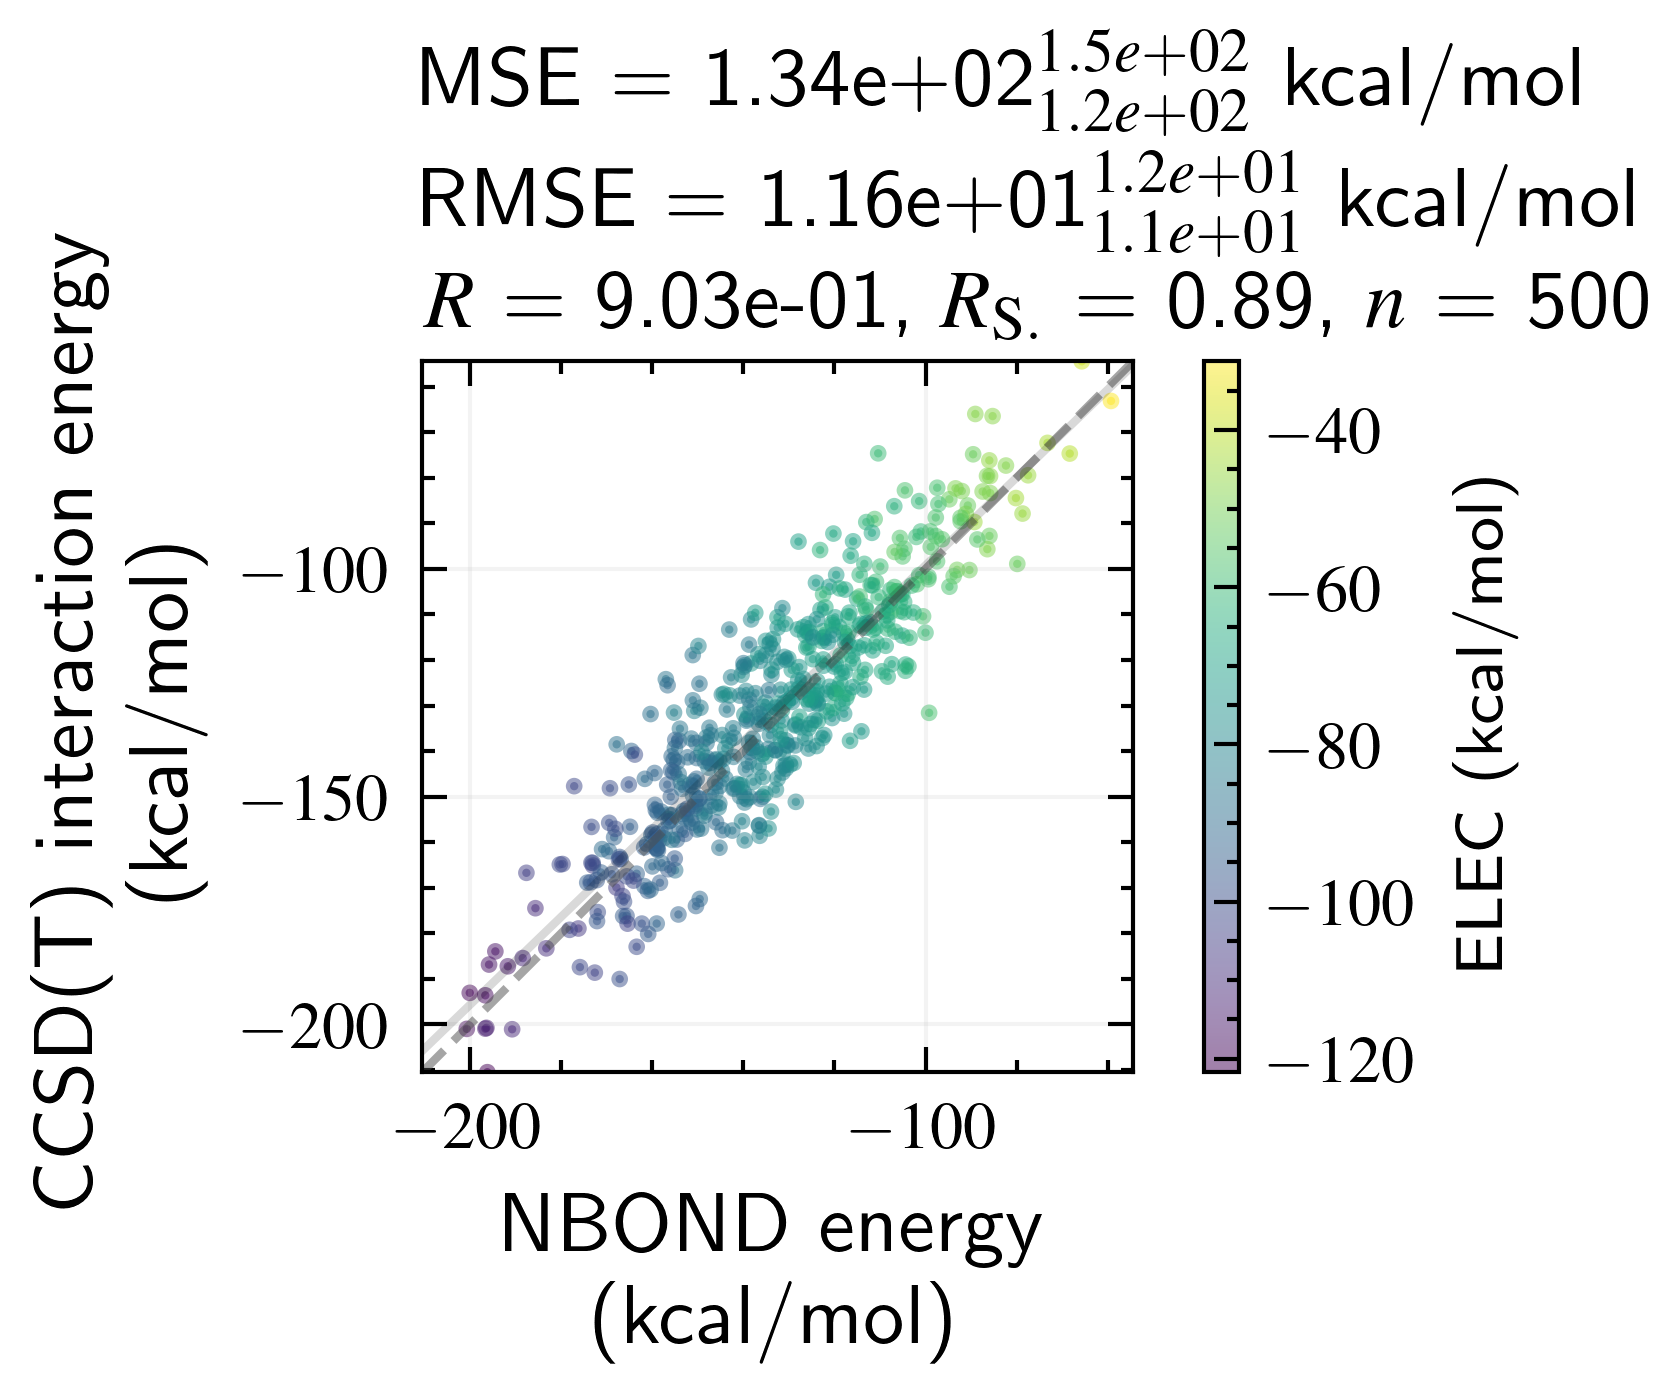

In [68]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC

plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")


0.0


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 3210.1909596343576,
  'RMSE': 56.65854710133642,
  'R': 0.974642974616211,
  'RS': 0.9712630530522122,
  'n': 500,
  'slope': 0.5898450470221722,
  'intercept': 0.7442057103565531})

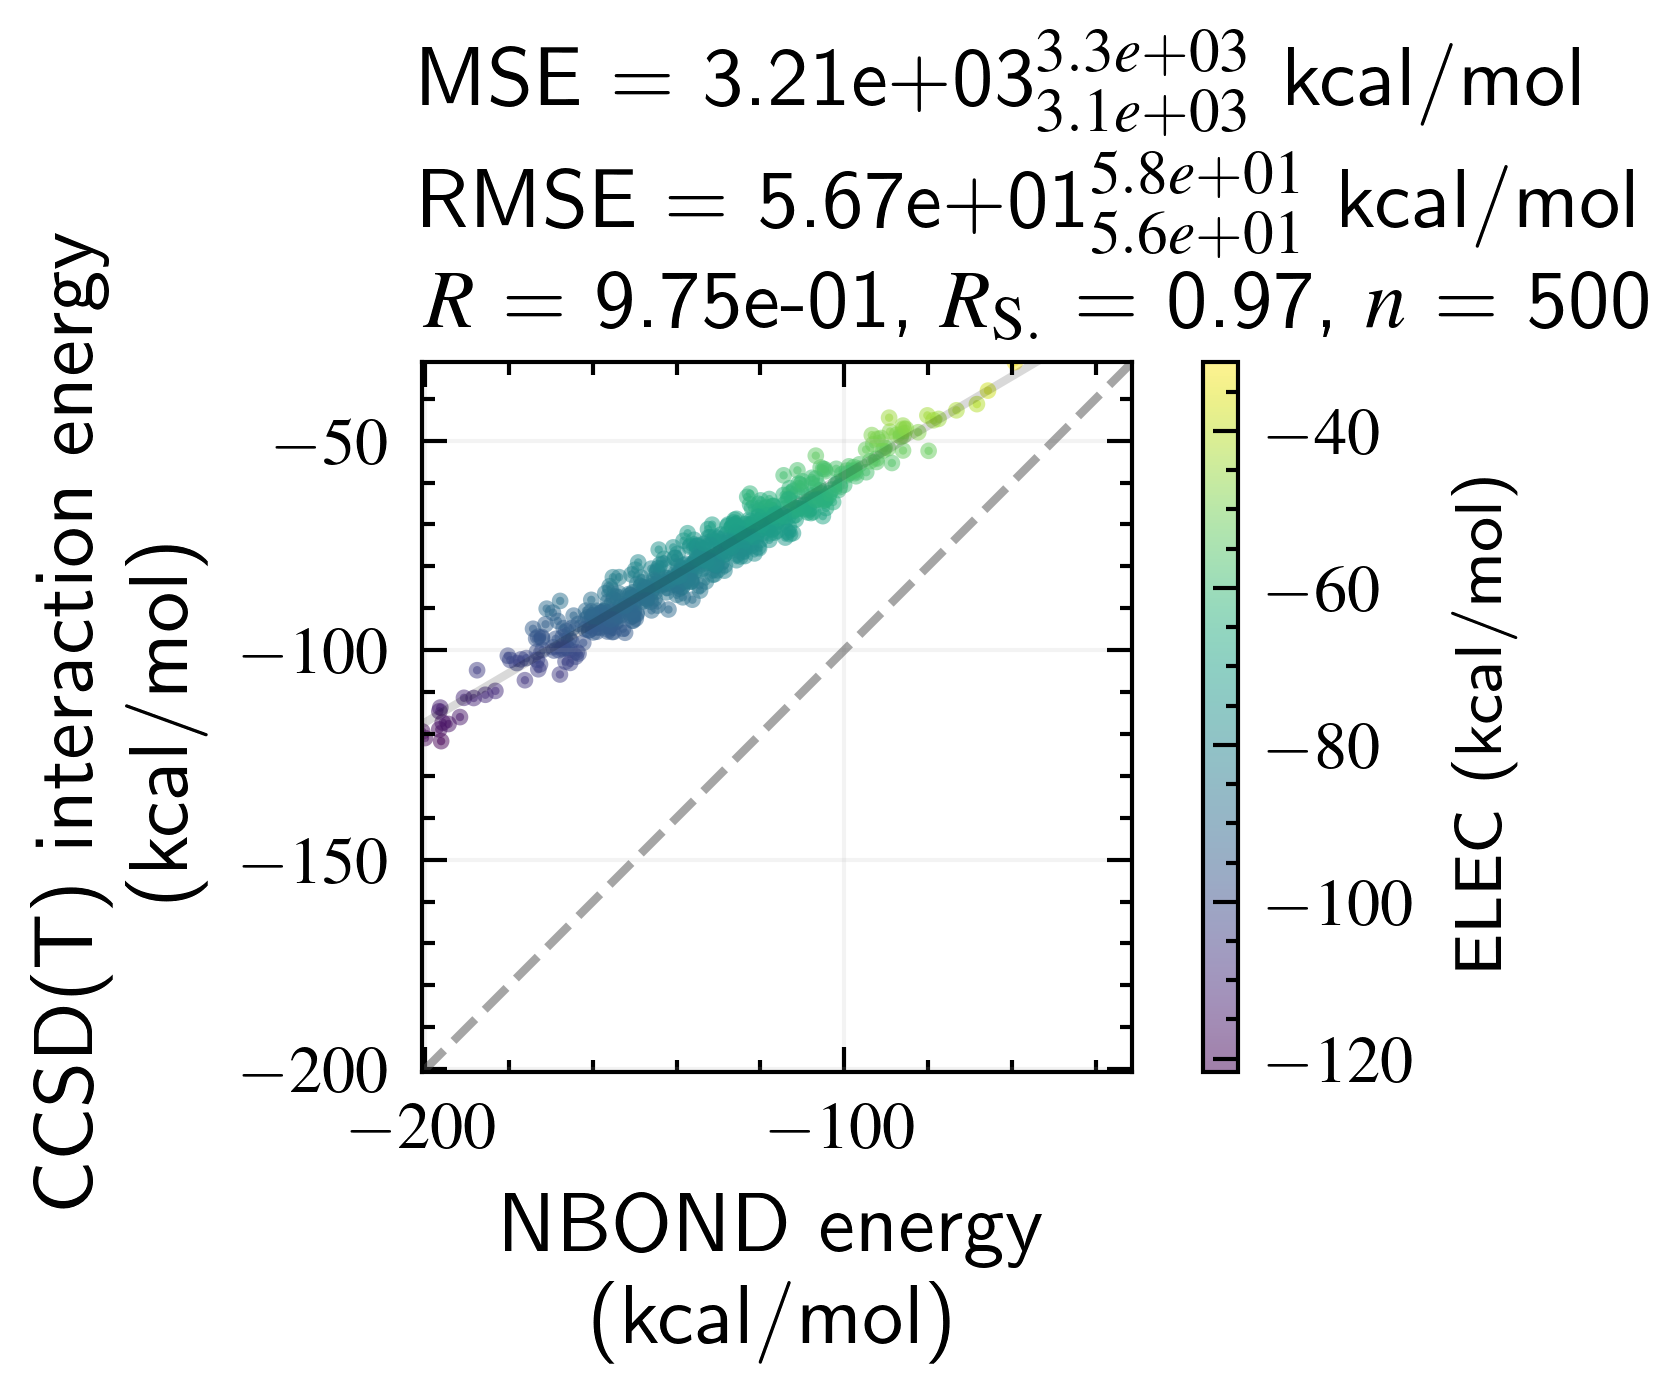

In [69]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")

In [70]:
pickle_output(_c, "ff/fit_ECOL_kmdcm_intE")

#  LJ fit


In [71]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))

LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"

LJFF.set_targets()


In [72]:
LJFF.targets.mean()

Array(72.72947, dtype=float32)

In [73]:
# _c.targets

In [74]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [75]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
11,121.053009,558,974,0,True,Optimization terminated successfully.,"[0.0310922460658211, 2.5, 0.001, 0.00398804354...","([[0.0310922460658211, 2.5, 0.001, 0.003988043..."
6,121.054955,506,873,0,True,Optimization terminated successfully.,"[0.001, 2.4999999599773766, 0.001, 0.003997777...","([[0.001, 2.4999999599773766, 0.001, 0.0039977..."
8,121.054977,744,1281,0,True,Optimization terminated successfully.,"[0.001, 2.499996663643654, 0.001, 0.0039978359...","([[0.001, 2.499996663643654, 0.001, 0.00399783..."
10,121.058022,632,1087,0,True,Optimization terminated successfully.,"[0.001, 2.5, 0.0011018609025912546, 0.00399531...","([[0.001, 2.5, 0.0011018609025912546, 0.003995..."
0,134.365814,114,283,0,True,Optimization terminated successfully.,"[380.78824548291703, 653.3039183068825, 595.13...","([[380.78824548291703, 653.3039183068825, 595...."
1,134.367233,112,300,0,True,Optimization terminated successfully.,"[1423.1511374311847, 822.9119734170063, 1517.3...","([[1423.1511374311847, 822.9119734170063, 1517..."
4,391.540314,275,499,0,True,Optimization terminated successfully.,"[1.8077053089519544, 0.8900914108605007, 0.001...","([[1.8077053089519544, 0.8900914108605007, 0.0..."
2,5605.217285,72,184,0,True,Optimization terminated successfully.,"[0.0838338928468173, 0.001, 0.0501980044660067...","([[0.0838338928468173, 0.001, 0.05019800446600..."
3,5605.217285,41,138,0,True,Optimization terminated successfully.,"[0.05533643411579958, 0.001, 2.5, 0.3029386621...","([[0.05533643411579958, 0.001, 2.5, 0.30293866..."
5,5605.217285,51,155,0,True,Optimization terminated successfully.,"[0.001, 0.001, 2.4422709694878115, 2.5]","([[0.001, 0.001, 2.4422709694878115, 2.5], [0...."


In [76]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

11.00240923767168

#  DE fit


In [83]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))
DEFF.elec = "fit_ECOL"
DEFF.intE = "intE"
DEFF.set_intE()
DEFF.set_targets()
print(DEFF.targets.mean())
DEFF

72.72947


FF: LJ water_cluster fit_ECOL harmonic intE (jax_coloumb: True)

In [84]:
fit_repeat(DEFF, 
           10, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [85]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
5,92.318748,868,1453,0,True,Optimization terminated successfully.,"[0.8831182816948127, 2.499992023965443, 2.4999...","([[0.8831182816948127, 2.499992023965443, 2.49..."
3,92.532715,1823,2857,0,True,Optimization terminated successfully.,"[0.8922658543992088, 2.4998530821839076, 2.212...","([[0.8922658543992088, 2.4998530821839076, 2.2..."
7,106.166962,1401,2251,0,True,Optimization terminated successfully.,"[0.9678466737925855, 2.416164859019997, 0.4478...","([[0.9678466737925855, 2.416164859019997, 0.44..."
2,114.561356,986,1614,0,True,Optimization terminated successfully.,"[0.2920727539261203, 2.4999966342365596, 0.232...","([[0.2920727539261203, 2.4999966342365596, 0.2..."
9,117.770126,916,1524,0,True,Optimization terminated successfully.,"[1.3890215705761144, 2.043302417144694, 0.0011...","([[1.3890215705761144, 2.043302417144694, 0.00..."
8,118.484070,1080,1774,0,True,Optimization terminated successfully.,"[0.3954464820087108, 2.1689533057548775, 0.014...","([[0.3954464820087108, 2.1689533057548775, 0.0..."
11,119.562508,465,823,0,True,Optimization terminated successfully.,"[0.0030632729838533553, 2.029067860017455, 0.0...","([[0.0030632729838533553, 2.029067860017455, 0..."
0,134.365814,114,283,0,True,Optimization terminated successfully.,"[380.78824548291703, 653.3039183068825, 595.13...","([[380.78824548291703, 653.3039183068825, 595...."
1,134.367233,112,300,0,True,Optimization terminated successfully.,"[1423.1511374311847, 822.9119734170063, 1517.3...","([[1423.1511374311847, 822.9119734170063, 1517..."
4,250.904053,541,933,0,True,Optimization terminated successfully.,"[2.5, 0.3623997241588276, 0.018397038252931347...","([[2.5, 0.3623997241588276, 0.0183970382529313..."


In [86]:
list(pd.DataFrame(\
                  _c.opt_results)\
     .sort_values("fun").x)[0]

array([380.78824548, 653.30391831, 595.13255835, 480.99707744,
       263.88581207])

In [87]:
best = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

9.608264592220651